In [1]:
import os
import shutil
import random
from tqdm import tqdm

# Set the seed for reproducibility
random.seed(42)

# Paths
source_dir = '/kaggle/input/paddy-disease-classification/train_images'
output_base = '/kaggle/working/dataset_split'  # New root folder for the split
splits = ['train', 'val', 'test']
split_ratios = [0.8, 0.1, 0.1]

for split in splits:
    for cls in os.listdir(source_dir):
        os.makedirs(os.path.join(output_base, split, cls), exist_ok=True)

for cls in tqdm(os.listdir(source_dir), desc="Splitting dataset by class"):
    cls_path = os.path.join(source_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    images = os.listdir(cls_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(split_ratios[0] * total)
    val_count = int(split_ratios[1] * total)

    train_files = images[:train_count]
    val_files = images[train_count:train_count + val_count]
    test_files = images[train_count + val_count:]

    for split_name, files in zip(splits, [train_files, val_files, test_files]):
        for file in files:
            src = os.path.join(cls_path, file)
            dst = os.path.join(output_base, split_name, cls, file)
            shutil.copy2(src, dst)

print("split.")


Splitting dataset by class: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]

split.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Large
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
from tensorflow.keras import layers, models
import shutil
import random

2025-05-28 08:06:08.390974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748419568.412551     167 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748419568.419197     167 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.models import load_model
model = load_model("/kaggle/input/mobilenetv3notfinetuned/tensorflow2/default/1/Mobilenetv3large_paddy_disease_detection_architecture_3_not_fine_tuned.keras")

I0000 00:00:1748419575.834122     167 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748419575.834762     167 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sb

original_dir = "/kaggle/input/paddy-disease-classification/train_images"

class_names = sorted(os.listdir(original_dir))
class_counts = []

for class_name in class_names:
    class_path = os.path.join(original_dir, class_name)
    count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts.append(count)

plt.figure(figsize=(12, 6))
sb.barplot(x=class_names, y=class_counts)
plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


plt.figure(figsize=(10, 10))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(original_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg'))]
    
    if image_files:
        image_path = os.path.join(class_path, image_files[0])  # Take the first image
        img = mpimg.imread(image_path)
        
        plt.subplot(2, 5, i+1)  # 2 rows x 5 columns for 10 classes
        plt.imshow(img)
        plt.title(class_name, fontsize=12)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
train_dir="/kaggle/working/dataset_split/train"
valid_dir= "/kaggle/working/dataset_split/val"
test_dir="/kaggle/working/dataset_split/test"


#  data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.05, 0.05),
])

# augmentation + preprocessing
def process_with_aug(image, label):
    image = data_augmentation(image) 
    image = preprocess_input(image)   
    return image, label
    
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='categorical',
    shuffle=True,
    seed=22
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='categorical',
    shuffle=False,
    seed=22
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='categorical',
    shuffle=False,
    seed=22
)

train_ds = train_ds.map(process_with_aug, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.cache()
test_ds = test_ds.cache()

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 8323 files belonging to 10 classes.
Found 1036 files belonging to 10 classes.
Found 1048 files belonging to 10 classes.


In [ ]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  
x = base_model.output
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4))(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           
    patience=3,           
    min_lr=1e-6           
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   
    patience=6,            
    restore_best_weights=True 
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=130,
    callbacks=[reduce_lr, early_stopping]
)

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in test_ds:  # or val_ds
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


I0000 00:00:1748419611.988914     221 service.cc:148] XLA service 0x79d2640433e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748419611.990325     221 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748419611.990344     221 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748419612.558176     221 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step


I0000 00:00:1748419618.140310     221 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [6]:
from sklearn.metrics import precision_score

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print(f"Precision (macro): {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.8831 - loss: 0.6019
Test accuracy : 0.8998091816902161
Precision (macro): 0.8997
Accuracy: 0.8998
Recall (macro): 0.8789
F1-score (macro): 0.8874
Confusion Matrix:
[[ 41   1   1   1   2   0   1   0   1   1]
 [  0  32   0   4   2   0   0   0   0   0]
 [  0   0  28   0   1   5   0   0   1   0]
 [  0   0   0 162   4   0   2   0   0   7]
 [  0   1   0   2  87   1   0   1   1   4]
 [  0   0   1   1   1 137   1   1   2   1]
 [  1   1   0   7   3   0  50   0   0   0]
 [  1   0   0   3   8   0   2 141   2   3]
 [  1   0   0   6   1   3   1   3 161   1]
 [  1   0   0   2   2   0   0   1   0 104]]


Test accuracy        : 0.8998
Precision (macro)    : 0.8997
Recall (macro)       : 0.8789
F1-score (macro)     : 0.8874
Confusion Matrix:
[[ 41   1   1   1   2   0   1   0   1   1]
 [  0  32   0   4   2   0   0   0   0   0]
 [  0   0  28   0   1   5   0   0   1   0]
 [  0   0   0 162   4   0   2   0   0   7]
 [  0   1   0   2  87   1   0   1   1   4]
 [  0   0   1   1   1 137   1   1   2   1]
 [  1   1   0   7   3   0  50   0   0   0]
 [  1   0   0   3   8   0   2 141   2   3]
 [  1   0   0   6   1   3   1   3 161   1]
 [  1   0   0   2   2   0   0   1   0 104]]


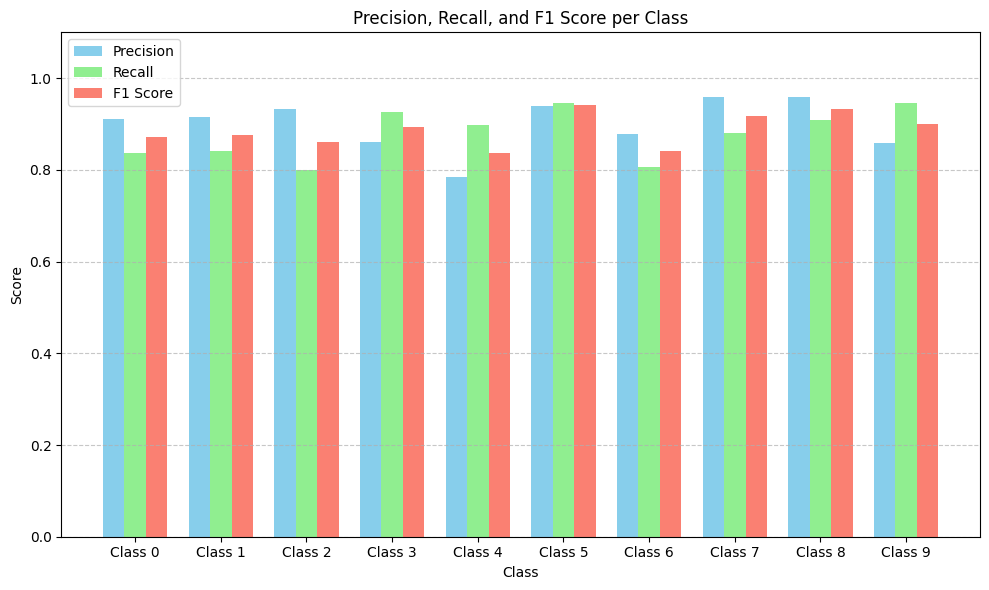

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Evaluate overall performance (macro)
accuracy = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Evaluate per-class metrics
classes = np.unique(y_true)
precision_per_class = precision_score(y_true, y_pred, average=None, labels=classes)
recall_per_class = recall_score(y_true, y_pred, average=None, labels=classes)
f1_per_class = f1_score(y_true, y_pred, average=None, labels=classes)

# Print macro metrics and confusion matrix
print(f"Test accuracy        : {accuracy:.4f}")
print(f"Precision (macro)    : {precision_macro:.4f}")
print(f"Recall (macro)       : {recall_macro:.4f}")
print(f"F1-score (macro)     : {f1_macro:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plotting per-class metrics
x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision_per_class, width, label='Precision', color='skyblue')
plt.bar(x, recall_per_class, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1_per_class, width, label='F1 Score', color='salmon')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score per Class')
plt.xticks(x, [f'Class {cls}' for cls in classes])
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


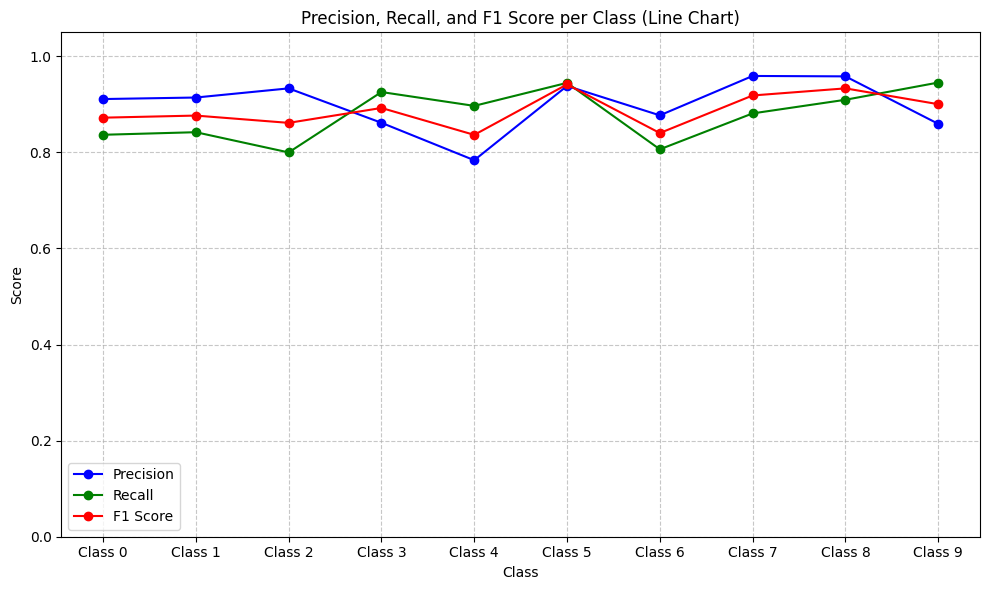

In [8]:
plt.figure(figsize=(10, 6))

plt.plot(classes, precision_per_class, marker='o', label='Precision', color='blue')
plt.plot(classes, recall_per_class, marker='o', label='Recall', color='green')
plt.plot(classes, f1_per_class, marker='o', label='F1 Score', color='red')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score per Class (Line Chart)')
plt.xticks(classes, [f'Class {cls}' for cls in classes])
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


Accuracy: 0.8998
Precision (macro): 0.8997
Recall (macro): 0.8789
F1-score (macro): 0.8874
Confusion Matrix:
[[ 41   1   1   1   2   0   1   0   1   1]
 [  0  32   0   4   2   0   0   0   0   0]
 [  0   0  28   0   1   5   0   0   1   0]
 [  0   0   0 162   4   0   2   0   0   7]
 [  0   1   0   2  87   1   0   1   1   4]
 [  0   0   1   1   1 137   1   1   2   1]
 [  1   1   0   7   3   0  50   0   0   0]
 [  1   0   0   3   8   0   2 141   2   3]
 [  1   0   0   6   1   3   1   3 161   1]
 [  1   0   0   2   2   0   0   1   0 104]]


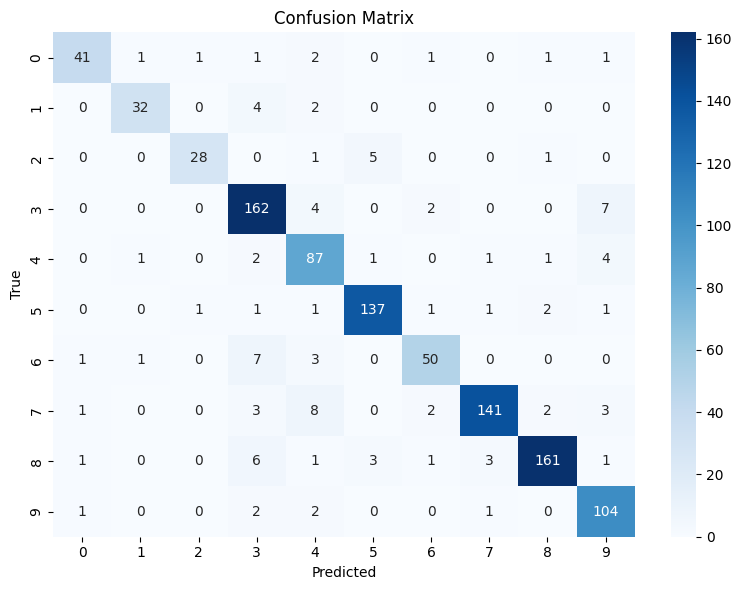


Classification Report:
              precision    recall  f1-score
0              0.911111  0.836735  0.872340
1              0.914286  0.842105  0.876712
2              0.933333  0.800000  0.861538
3              0.861702  0.925714  0.892562
4              0.783784  0.896907  0.836538
5              0.938356  0.944828  0.941581
6              0.877193  0.806452  0.840336
7              0.959184  0.881250  0.918567
8              0.958333  0.909605  0.933333
9              0.859504  0.945455  0.900433
accuracy       0.899809  0.899809  0.899809
macro avg      0.899679  0.878905  0.887394
weighted avg   0.903594  0.899809  0.900195


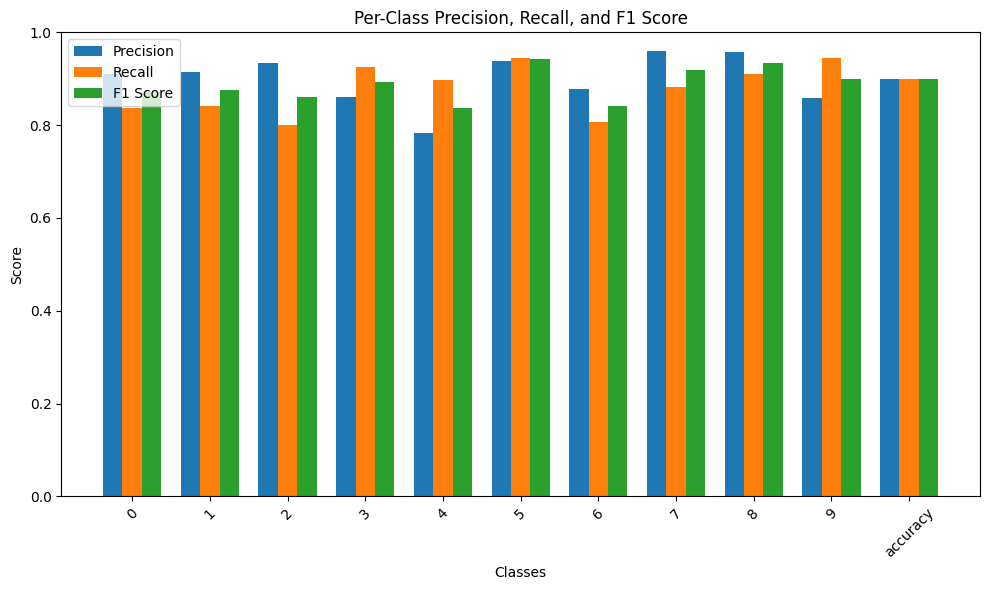

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import pandas as pd

# Example true and predicted labels (replace with yours)
# y_true = [...]
# y_pred = [...]

# Overall (macro) metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# 🔹 Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# 🔹 Classification Report Table and Bar Plot
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(df_report[['precision', 'recall', 'f1-score']])

# Only keep actual class rows (not 'accuracy', 'macro avg', etc.)
class_labels = [label for label in df_report.index if label.isdigit() or label.isalpha()]
df_class = df_report.loc[class_labels]

# Bar Plot
x = np.arange(len(class_labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, df_class['precision'], width, label='Precision')
plt.bar(x, df_class['recall'], width, label='Recall')
plt.bar(x + width, df_class['f1-score'], width, label='F1 Score')
plt.xticks(x, class_labels, rotation=45)
plt.ylim(0, 1)
plt.title('Per-Class Precision, Recall, and F1 Score')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
model = load_model("/kaggle/input/mobilenetv3largefinetuned/tensorflow2/default/1/Mobilenetv3large_paddy_disease_detection_architecture_3_fine_tuned.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 50 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in test_ds:  # or val_ds
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [12]:
from sklearn.metrics import precision_score

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print(f"Precision (macro): {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 0.9007 - loss: 0.5123
Test accuracy : 0.9036259651184082
Precision (macro): 0.9026
Accuracy: 0.9036
Recall (macro): 0.8929
F1-score (macro): 0.8963
Confusion Matrix:
[[ 42   1   0   0   1   0   5   0   0   0]
 [  0  32   0   1   1   0   1   1   0   2]
 [  0   0  33   0   0   1   0   0   0   1]
 [  0   0   0 166   2   0   2   1   2   2]
 [  1   0   0   2  87   0   2   0   2   3]
 [  0   1   0   2   1 138   2   0   1   0]
 [  0   1   0   2   4   0  51   1   3   0]
 [  1   1   0   7  10   1   4 130   4   2]
 [  0   0   0   4   1   0   1   2 169   0]
 [  0   0   0   3   2   0   1   4   1  99]]


Accuracy: 0.9036
Precision (macro): 0.9026
Recall (macro): 0.8929
F1-score (macro): 0.8963
Confusion Matrix:
[[ 42   1   0   0   1   0   5   0   0   0]
 [  0  32   0   1   1   0   1   1   0   2]
 [  0   0  33   0   0   1   0   0   0   1]
 [  0   0   0 166   2   0   2   1   2   2]
 [  1   0   0   2  87   0   2   0   2   3]
 [  0   1   0   2   1 138   2   0   1   0]
 [  0   1   0   2   4   0  51   1   3   0]
 [  1   1   0   7  10   1   4 130   4   2]
 [  0   0   0   4   1   0   1   2 169   0]
 [  0   0   0   3   2   0   1   4   1  99]]


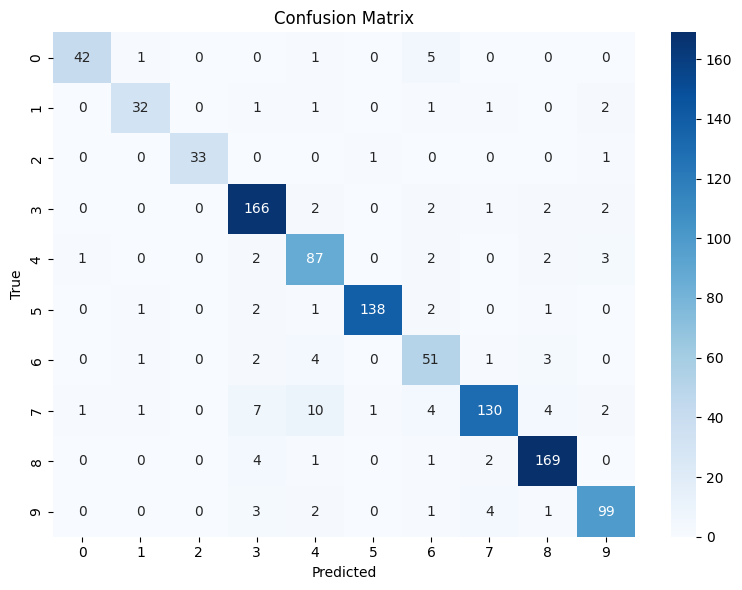


Classification Report:
              precision    recall  f1-score
0              0.954545  0.857143  0.903226
1              0.888889  0.842105  0.864865
2              1.000000  0.942857  0.970588
3              0.887701  0.948571  0.917127
4              0.798165  0.896907  0.844660
5              0.985714  0.951724  0.968421
6              0.739130  0.822581  0.778626
7              0.935252  0.812500  0.869565
8              0.928571  0.954802  0.941504
9              0.908257  0.900000  0.904110
accuracy       0.903626  0.903626  0.903626
macro avg      0.902622  0.892919  0.896269
weighted avg   0.907424  0.903626  0.904053


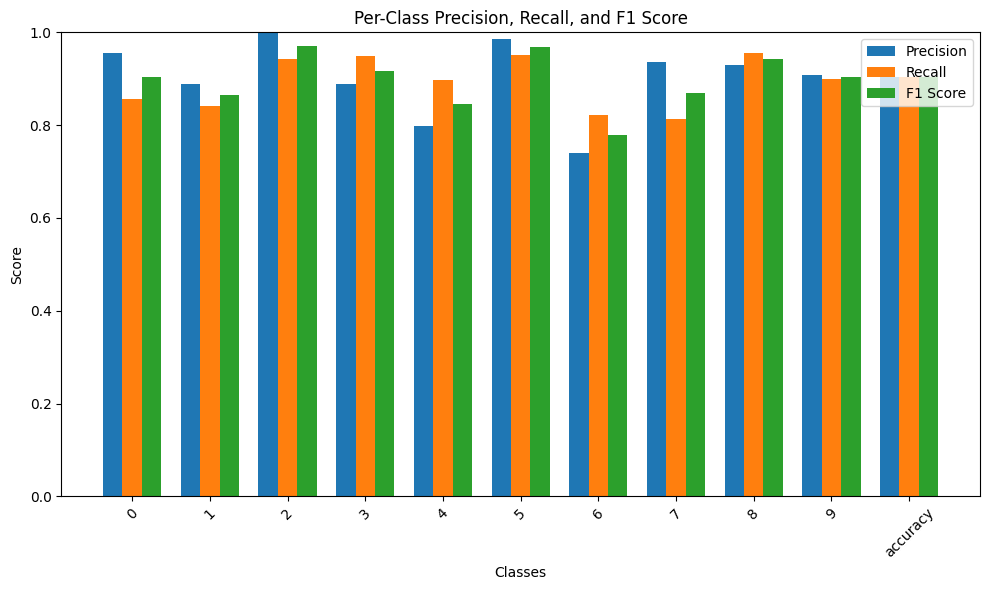

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import pandas as pd

# Example true and predicted labels (replace with yours)
# y_true = [...]
# y_pred = [...]

# Overall (macro) metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# 🔹 Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# 🔹 Classification Report Table and Bar Plot
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(df_report[['precision', 'recall', 'f1-score']])

# Only keep actual class rows (not 'accuracy', 'macro avg', etc.)
class_labels = [label for label in df_report.index if label.isdigit() or label.isalpha()]
df_class = df_report.loc[class_labels]

# Bar Plot
x = np.arange(len(class_labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, df_class['precision'], width, label='Precision')
plt.bar(x, df_class['recall'], width, label='Recall')
plt.bar(x + width, df_class['f1-score'], width, label='F1 Score')
plt.xticks(x, class_labels, rotation=45)
plt.ylim(0, 1)
plt.title('Per-Class Precision, Recall, and F1 Score')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

classes = np.unique(y_true)
precision = precision_score(y_true, y_pred, average=None, labels=classes)
recall = recall_score(y_true, y_pred, average=None, labels=classes)
f1 = f1_score(y_true, y_pred, average=None, labels=classes)

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1, width, label='F1 Score', color='salmon')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score per Class')
plt.xticks(x, [f'Class {cls}' for cls in classes])
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred))


In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are your ground truths and predictions
conf_mat = confusion_matrix(y_true, y_pred)

# Optional: If you have class labels
class_names = ['bacterial leaf blight', 'bacterial leaf streak', 'bacterial panicle blight',
               'blast', 'brown spot', 'dead heart', 'downy mildew', 'hispa',
               'normal', 'tungro']  # Update with your class labels

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
model_save_path = '/kaggle/working/Mobilenetv3large_paddy_disease_detection_architecture_3_not_fine_tuned_updated.h5'
model.save(model_save_path)

In [ ]:
model.save("Mobilenetv3large_paddy_disease_detection_architecture_3_not_fine_tuned_updated.keras")


In [ ]:
baseline_model = tf.keras.models.load_model("/kaggle/working/Mobilenetv3large_paddy_disease_detection_architecture_3_not_fine_tuned_updated.keras")

base_model = model.layers[2]

base_model.trainable = True

for layer in model.layers[140:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,  
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:  # or val_ds
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [ ]:
from sklearn.metrics import precision_score

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print(f"Precision (macro): {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred))


In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred)

# Optional: If you have class labels
class_names = ['bacterial leaf blight', 'bacterial leaf streak', 'bacterial panicle blight',
               'blast', 'brown spot', 'dead heart', 'downy mildew', 'hispa',
               'normal', 'tungro']  
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
model_save_path = '/kaggle/working/Mobilenetv3large_paddy_disease_detection_architecture_3_fine_tuned_updated.h5'
model.save(model_save_path)

In [ ]:
model.save("Mobilenetv3large_paddy_disease_detection_architecture_3_fine_tuned_updated.keras")


In [ ]:

import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
    
download_file('/kaggle/working/Mobilenetv3large_paddy_disease_detection_architecture_3_fine_tuned_updated.keras', 'out')